# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
3. [Homework](#homework)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

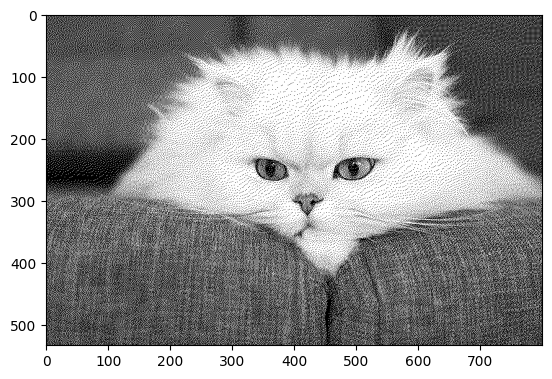

In [5]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [6]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

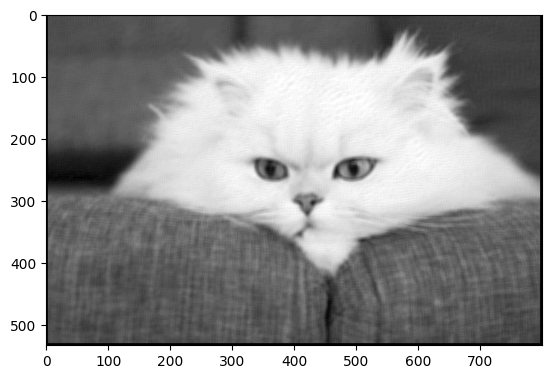

In [7]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [8]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-8-7c8c44ebc1df>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


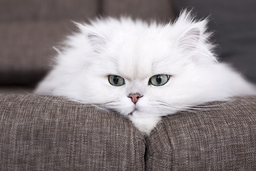

In [9]:
img

In [10]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [11]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [12]:
input = to_tensor(img)
input.shape


torch.Size([1, 171, 256])

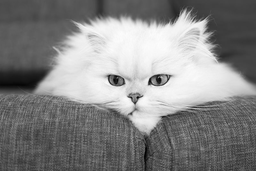

In [13]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [14]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [15]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.1562, -0.0415, -0.0407,  ..., -0.0348, -0.0348, -0.0306],
         [-0.2835, -0.1559, -0.1559,  ..., -0.1345, -0.1345, -0.0646],
         [-0.2791, -0.1560, -0.1559,  ..., -0.1305, -0.1312, -0.0639],
         ...,
         [-0.2582, -0.1767, -0.1837,  ..., -0.1386, -0.1403, -0.0712],
         [-0.2385, -0.1553, -0.1868,  ..., -0.1412, -0.0948, -0.0716],
         [-0.1414, -0.0829, -0.0937,  ..., -0.0648, -0.0586, -0.0612]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [16]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 171, 256])

In [17]:
output = conv(input)
output.shape

torch.Size([1, 1, 171, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [18]:
output.shape

torch.Size([1, 1, 171, 256])

We need to remove the first dimension before converting to a PIL object.

In [19]:
output.data.squeeze(dim=0).shape

torch.Size([1, 171, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

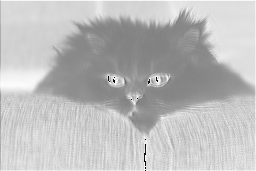

In [20]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

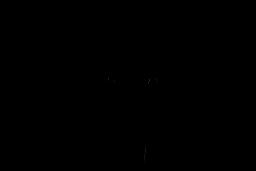

In [21]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [22]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

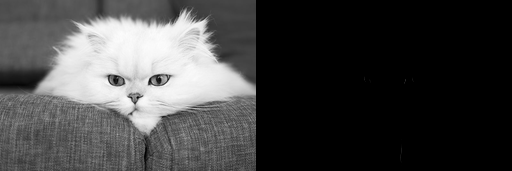

In [24]:
display(input, output)

### Identity

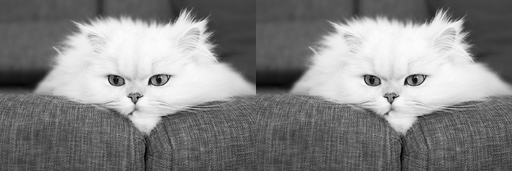

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


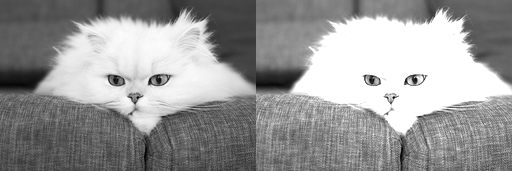

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


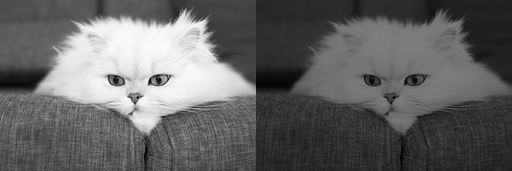

In [27]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


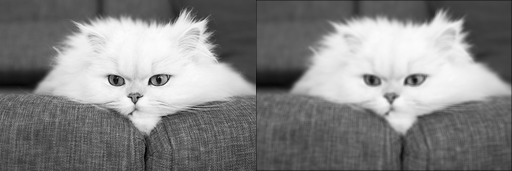

In [28]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


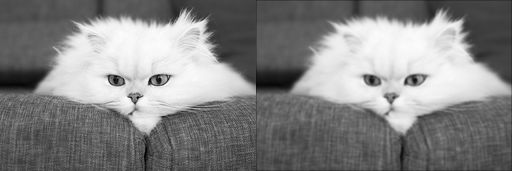

In [29]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


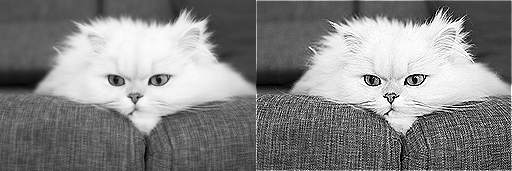

In [30]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


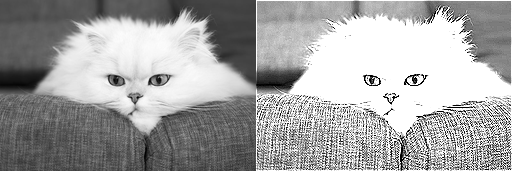

In [31]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


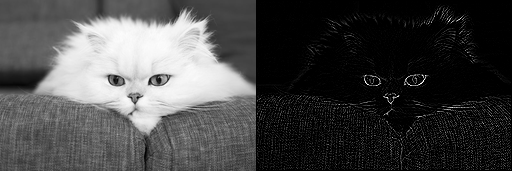

In [32]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

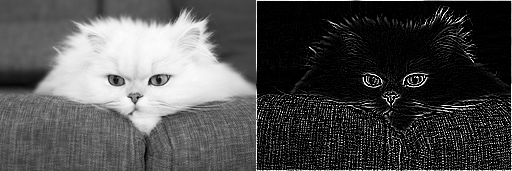

In [33]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

## Homework: Additional exercises  <a class="anchor" id="homework"></a>

### Implement the following line detectors using Python code (i.e. without using OpenCV libraries): Prewitt, Sobel and Laplacian. Investigate the algorithmic complexity of these, which is more efficient?

In [81]:
def display_image(image, title):
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.axis('off')

In [82]:
image = Image.open('data/image.jpg')
input = to_tensor(image)
input = input.squeeze(0).numpy()

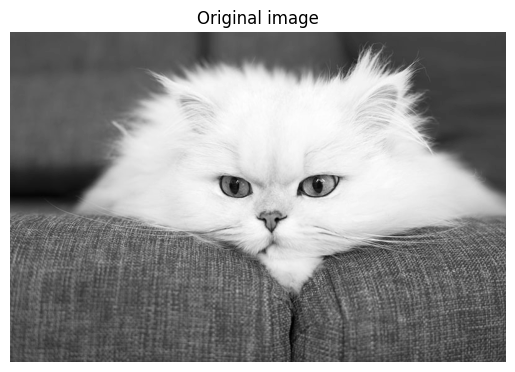

In [83]:
display_image(input, 'Imagen original')

In [84]:
# The same functions are used by the three operators, so we can define general use convolutional utils.
 
def convolve(image, mask):
  return np.sum(np.multiply(image, mask[::-1, ::-1]))

def apply_mask(image, mask):
  m, n = mask.shape
  y, x = image.shape
  y = y - m + 1
  x = x - n + 1
  result = np.zeros((y, x))
  for i in range(y):
      for j in range(x):
          result[i, j] = convolve(image[i:i+m, j:j+n], mask)
  return result

#### 1.1. Prewitt

In [85]:
def prewitt_operator(image):
  vertical_mask = np.array([[-1, 0, 1]]*3) # Since for this operator the matrices defined are exactly the same, use comprehension list definition.
  horizontal_mask = np.array([[-1]*3, [0]*3,[1]*3])

  gradient_x = apply_mask(image, vertical_mask)
  gradient_y = apply_mask(image, horizontal_mask)

  return np.sqrt(gradient_x**2 + gradient_y**2)

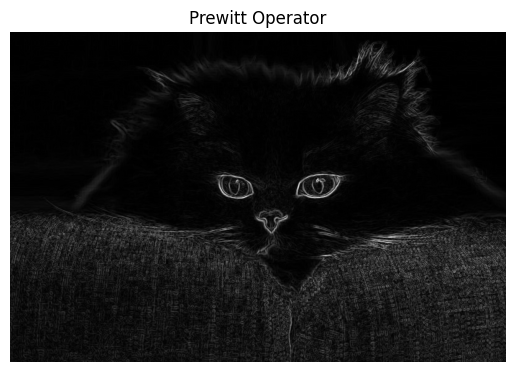

In [86]:
prewitt_result = prewitt_operator(input)

display_image(prewitt_result, 'Prewitt Operator')

#### 1.2. Sobel

In [87]:
def sobel_operator(image):
  vertical_mask = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  horizontal_mask = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  gradient_x = apply_mask(image, vertical_mask)
  gradient_y = apply_mask(image, horizontal_mask)

  return np.sqrt(gradient_x**2 + gradient_y**2)

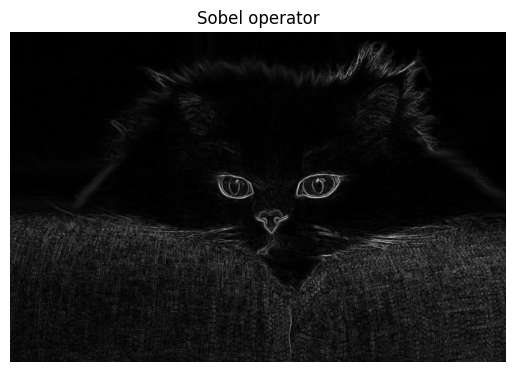

In [89]:
sobel_result = sobel_operator(input)

display_image(sobel_result, 'Sobel operator')

#### 1.3. Laplacian

In [94]:
def laplacian_operator(image):
  laplacian_mask = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

  laplacian_result = apply_mask(image, laplacian_mask)

  return laplacian_result


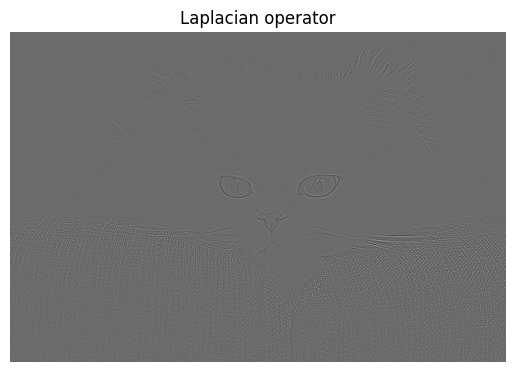

In [95]:
laplacian_result = laplacian_operator(input)

display_image(laplacian_result, 'Laplacian operator')

The computational complexity of the Prewitt, Sobel and Laplacian convolution operators depends on the image size and the size of the mask used in the convolution. Therefore, the complexity of the image can be expressed using:

* `m` x `n` as the size of the image (pixels).
* The size of all the mask matrices is `3 x 3 = 9`.

1. **Prewitt Operator:**
     * Convolution using the Prewitt operator involves two separate steps for the horizontal and vertical derivatives. Each step involves a double loop that loops through the image and applies a kernel of size `3 x 3` .
     * The total computational complexity can be expressed as `O(2*(m * n * 9))`, simplified as `O(m * n * 18)`.
2. **Sobel Operator:**
     * Similar to Prewitt, the Sobel operator also performs two separate steps for the horizontal and vertical derivatives.
     * The computational complexity for this mask type is also `O(m * n * 18)`.
3. **Laplacian Operator:**
     * The Laplacian operator involves a single step that applies a similar mask of size 3x3.
     * Therefore, the complexity would be `O(m * n * 9)`.